### Time Series Forecasting

In [266]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Define seaborn's color palette
color_pal = sns.color_palette()

In [267]:
# Read the dataset
data = pd.read_csv('dataset.txt',delimiter=';')

C:\Users\strat\AppData\Local\Temp\ipykernel_9236\2982743396.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.txt',delimiter=';')


In [268]:
# Shape of the dataset
data.shape

(140256, 371)

In [269]:
# Print first rows of dataset
data.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


### Data Preprocessing

In [270]:
# Change name of first column in dataset
data.rename(columns = {'Unnamed: 0':'Timestamps'}, inplace = True)

In [271]:
# We do not want our data types to be objects
data.dtypes

Timestamps    object
MT_001        object
MT_002        object
MT_003        object
MT_004        object
               ...  
MT_366        object
MT_367        object
MT_368        object
MT_369        object
MT_370        object
Length: 371, dtype: object

In [272]:
# Convert string Timestamps into datetime
data['Timestamps'] = pd.to_datetime(data['Timestamps'], format='%Y-%m-%d %H:%M:%S')

In [273]:
# Convert data types of numerical columns from object to float
for i in data.columns:
    if i == 'Timestamps':
        continue
    else:
        data[i] = data[i].replace(',','.', regex=True).astype({i:'float'})

In [274]:
# Now the data types are the appropriate ones
data.dtypes

Timestamps    datetime64[ns]
MT_001               float64
MT_002               float64
MT_003               float64
MT_004               float64
                   ...      
MT_366               float64
MT_367               float64
MT_368               float64
MT_369               float64
MT_370               float64
Length: 371, dtype: object

In [275]:
# Divide the numerical values by 4
# In order to have kWh instead of kW/15 minutes
for i in data.columns:
    if i == 'Timestamps':
        continue
    else:
        data[i] = data[i].div(4)

In [276]:
# Set the Timestamps as the index of the dataframe
data = data.set_index('Timestamps')

In [277]:
# Preview of the new dataset
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Timestamps,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
# Define a new column (the sum of energy consumption in a specific timestamp)
data['Consumption_Sum'] = data.sum(axis=1,numeric_only=True)

In [279]:
# Delete unecessary columns
for i in data.columns:
    if i == 'Timestamps' or i == 'Consumption_Sum':
        continue
    else:
        data.drop(i, inplace=True, axis=1)

In [280]:
data.head()

,Consumption_Sum
Timestamps,
2011-01-01 00:15:00,17128.278835
2011-01-01 00:30:00,17295.076090
2011-01-01 00:45:00,17341.212643
2011-01-01 01:00:00,17087.620165
2011-01-01 01:15:00,16541.718576


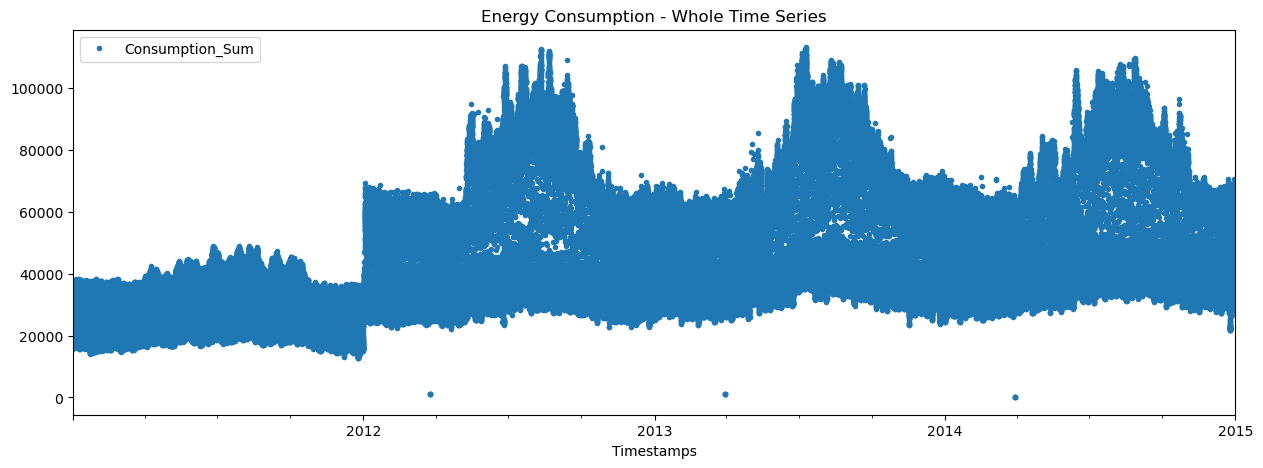

In [281]:
# Plot the whole time series
data.plot(style='.',figsize=(15, 5),color=color_pal[0],title='Energy Consumption - Whole Time Series')
plt.show()

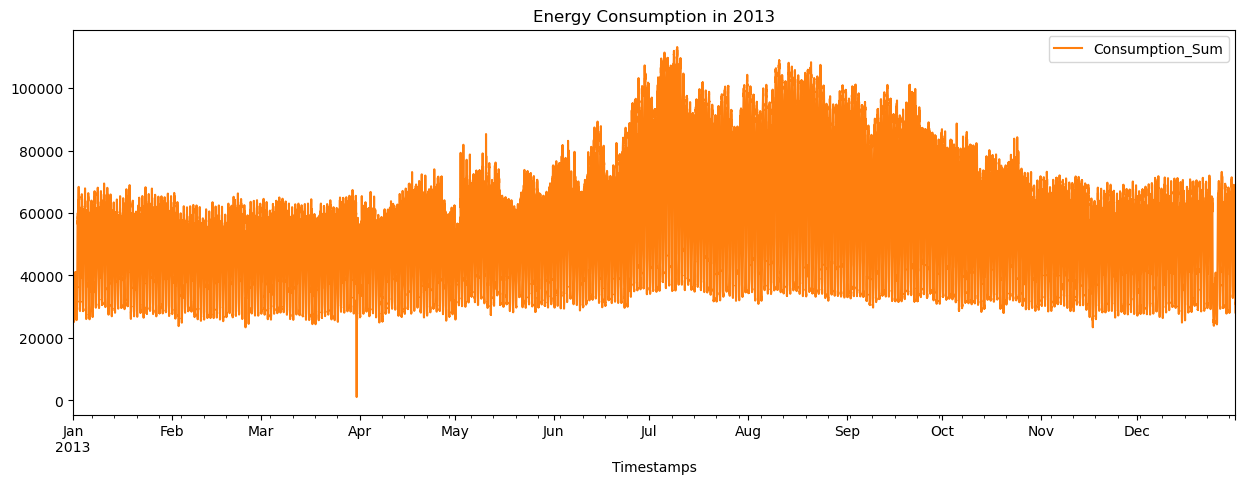

In [282]:
# Plot the energy consumption in 2013
data.loc[(data.index >= '2013-01-01') & (data.index < '2014-01-01')].plot(figsize=(15, 5),color=color_pal[1], title='Energy Consumption in 2013')
plt.show()

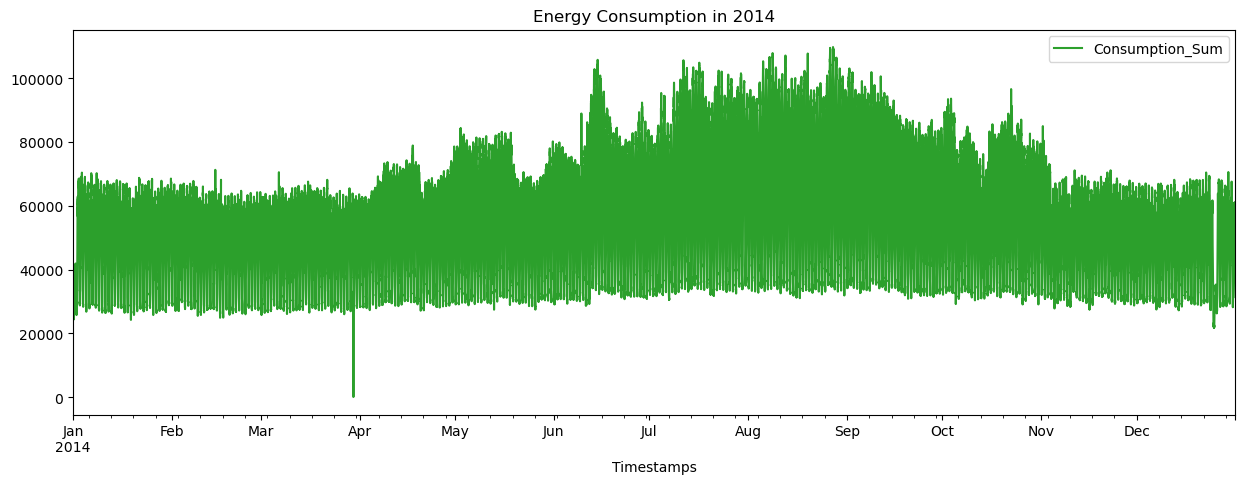

In [283]:
# Plot the energy consumption in 2014
data.loc[(data.index < '2015-01-01') & (data.index >= '2014-01-01')].plot(figsize=(15, 5),color=color_pal[2], title='Energy Consumption in 2014')
plt.show()

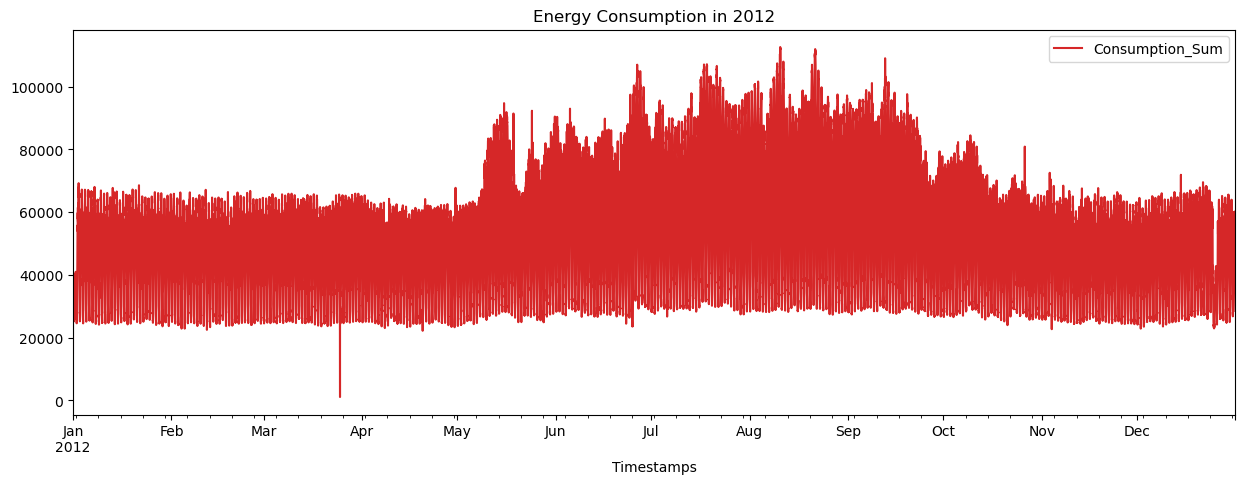

In [284]:
# Plot the energy consumption in 2012
data.loc[(data.index < '2013-01-01') & (data.index >= '2012-01-01')].plot(figsize=(15, 5),color=color_pal[3], title='Energy Consumption in 2012')
plt.show()

### Train / Test Split

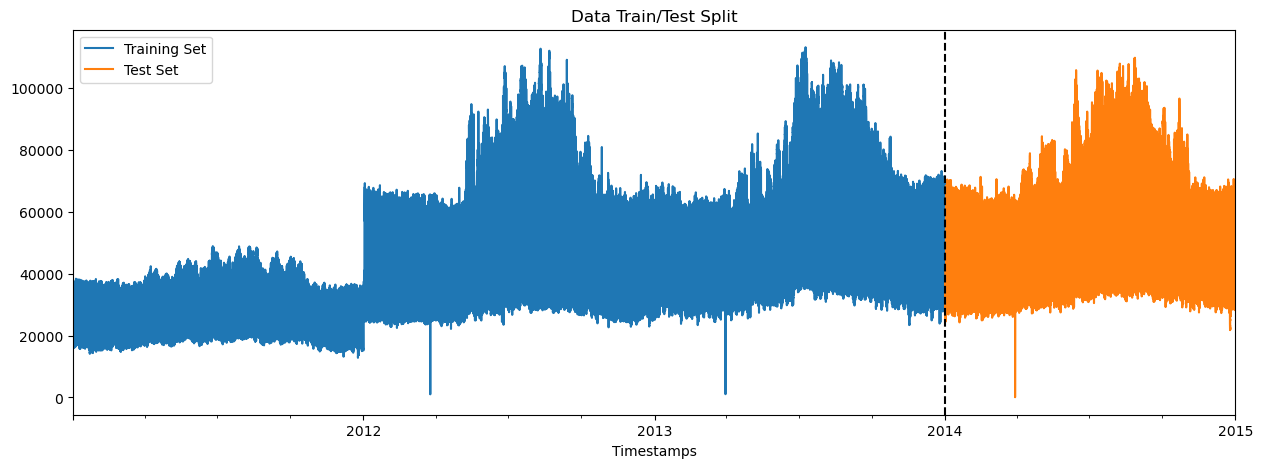

In [285]:
train = data.loc[data.index < '2014-01-01']
test = data.loc[data.index >= '2014-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2014-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Feature Creation

In [286]:
# We define some features that might be usefull to our research
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

data = create_features(data)

#### Define Features and Labels

In [287]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'year']
TARGET = 'Consumption_Sum'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [292]:
# Print the dataset
data.head()

,Consumption_Sum,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,prediction
Timestamps,,,,,,,,,
2011-01-01 00:15:00,17128.278835,0,5,1,2011,1,1,52,NaN
2011-01-01 00:30:00,17295.076090,0,5,1,2011,1,1,52,NaN
2011-01-01 00:45:00,17341.212643,0,5,1,2011,1,1,52,NaN
2011-01-01 01:00:00,17087.620165,1,5,1,2011,1,1,52,NaN
2011-01-01 01:15:00,16541.718576,1,5,1,2011,1,1,52,NaN


In [288]:
# We use a regressor as our model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=30,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

[23:33:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:50441.25149	validation_1-rmse:59046.03845
[100]	validation_0-rmse:20114.27472	validation_1-rmse:24312.80997
[200]	validation_0-rmse:9941.74707	validation_1-rmse:12412.03657
[300]	validation_0-rmse:6459.38888	validation_1-rmse:8198.06388
[400]	validation_0-rmse:5255.22220	validation_1-rmse:6677.19224
[500]	validation_0-rmse:4746.88164	validation_1-rmse:6059.87372
[600]	validation_0-rmse:4489.89526	validation_1-rmse:5787.93489
[700]	validation_0-rmse:4325.11193	validation_1-rmse:5627.00345
[800]	validation_0-rmse:4212.52110	validation_1-rmse:5521.65097
[900]	validation_0-rmse:4117.14837	validation_1-rmse:5442.37798
[999]	validation_0-rmse:4038.86137	validation_1-rmse:5378.05857


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=30, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

### Feature Importance

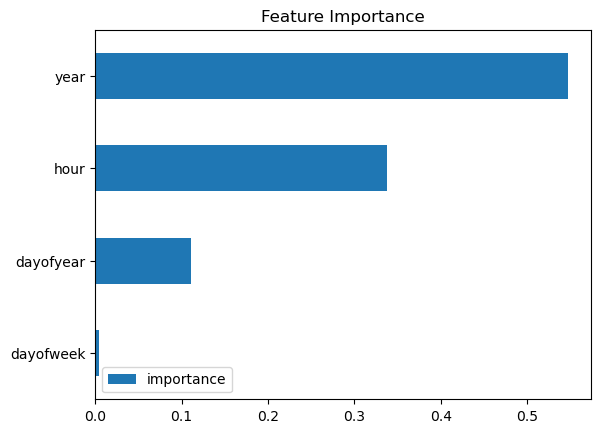

In [289]:
# Show how much each of the features was used in our regression analysis
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on test set

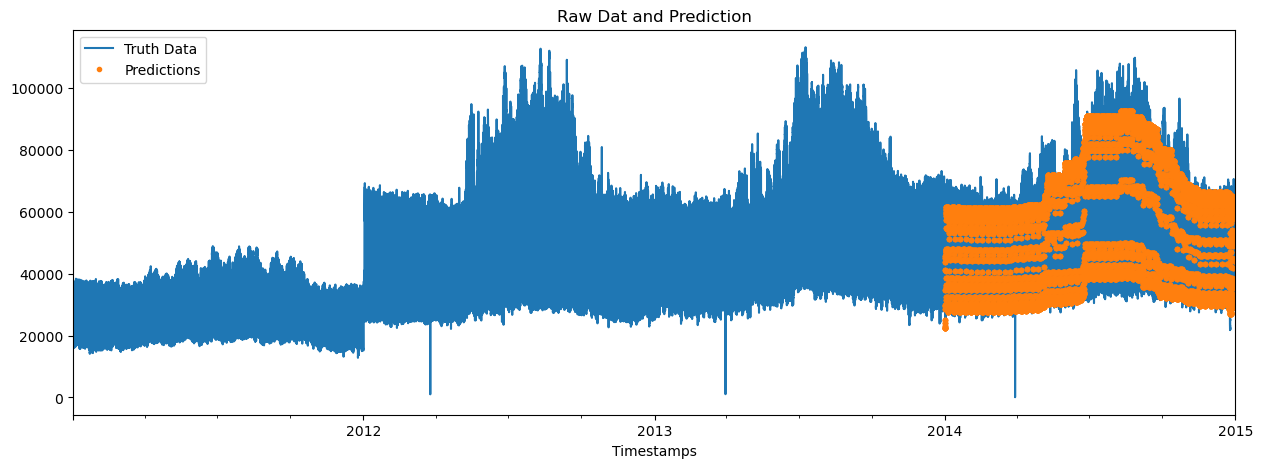

In [290]:
# Timeseries forecating on test set
test['prediction'] = reg.predict(X_test)

data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = data[['Consumption_Sum']].plot(figsize=(15, 5))
data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Estimate score

In [291]:
score = np.sqrt(mean_squared_error(test['Consumption_Sum'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 5378.06
